In [28]:
import pandas as pd
import numpy as np
import pymysql
import getpass
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_rows", 500)
%matplotlib inline
sns.set()
sns.set_style("ticks")

In [2]:
pw = getpass.getpass()

········


In [3]:
conn = pymysql.connect(host="localhost",
                       port=3306,
                       user="ironhack",
                       passwd=pw,
                       db="olist");

# Analyzing black friday 2017

Black Friday happened on Nov. 24th, 2017.
We are tasked to evaluate the success.

In [4]:
# 0.1
weekly_rev_query = """
SELECT
    DATE_SUB(DATE(o.order_purchase_timestamp), INTERVAL DAYOFWEEK(DATE(o.order_purchase_timestamp)) - 1 DAY) AS week_id,
    SUM(oi.price) AS revenue_generated
FROM order_items oi
    JOIN orders o
    ON oi.order_id = o.order_id
WHERE o.order_purchase_timestamp < '2018-01-15'
    AND o.order_purchase_timestamp > '2017-03-05'
GROUP BY 1
ORDER BY 1;
"""

weekly_revenue = pd.read_sql(weekly_rev_query, conn)

In [5]:
# 0.2
weekly_revenue.head()

,week_id,revenue_generated
0,2017-03-05,78704.619772
1,2017-03-12,95487.199723
2,2017-03-19,85260.389904
3,2017-03-26,83634.099916
4,2017-04-02,94745.860022


In [6]:
# 0.3
weekly_revenue.dtypes

week_id               object
revenue_generated    float64
dtype: object

In [8]:
# 0.4
weekly_revenue["week_id"] = pd.to_datetime(weekly_revenue["week_id"])

In [10]:
# 0.5
weekly_revenue = weekly_revenue.set_index("week_id")

## Approach 1:
Week over week comparison

In [11]:
# 1.1
week_comp = weekly_revenue.copy()

In [13]:
# 1.2
# Filter df for only the black friday week and the week prior
black_friday_week = "2017-11-19"
prior_week = "2017-11-12"
week_comp = week_comp.loc[prior_week:black_friday_week]

In [21]:
week_comp

,revenue_generated
week_id,
2017-11-12,178951.390068
2017-11-19,381809.340397


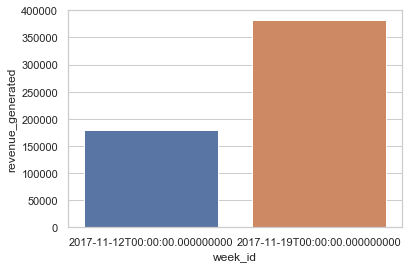

In [15]:
# 1.3 plot bars
sns.barplot(data=week_comp,
            x=week_comp.index,
            y="revenue_generated");

In [25]:
# 1.4 compute diffs
abs_diff_week_comp = week_comp.loc["2017-11-19", "revenue_generated"] - week_comp.loc["2017-11-12", "revenue_generated"]
rel_diff_week_comp = (week_comp.loc["2017-11-19", "revenue_generated"] / week_comp.loc["2017-11-12", "revenue_generated"]) - 1

print(f"""The revenue for the week of black friday increased by {round(rel_diff_week_comp * 100)}% compared to the week prior.
This represents an increase of revenue by {round(abs_diff_week_comp)} Reais.
""")

The revenue for the week of black friday increased by 113.0% compared to the week prior.
This represents an increase of revenue by 202858.0 Reais.



---

## Approach 2:
Accounting for the weeks after black friday

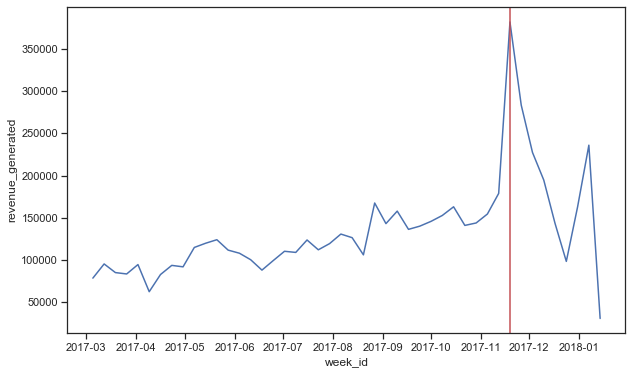

In [32]:
# 2.1 plot weekly_rev
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=weekly_revenue,
             x=weekly_revenue.index,
             y="revenue_generated",
             ax=ax);

ax.axvline("2017-11-19", color="r");

In [34]:
# 2.2
week_hangover = (weekly_revenue
                 .copy()
                 .loc["2017-11-12":"2017-12-31"])
week_hangover

,revenue_generated
week_id,
2017-11-12,178951.390068
2017-11-19,381809.340397
2017-11-26,283473.019732
2017-12-03,227372.830050
2017-12-10,194720.879677
2017-12-17,143431.610006
2017-12-24,98513.040154
2017-12-31,163005.200357


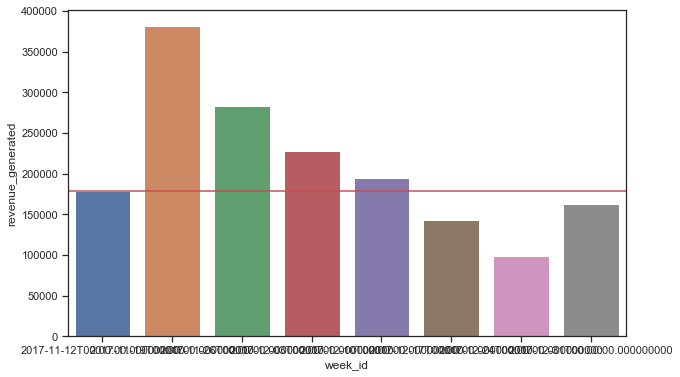

In [38]:
# 2.3
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=week_hangover,
            x=week_hangover.index,
            y="revenue_generated",
            ax=ax);
ax.axhline(week_hangover.loc["2017-11-12", "revenue_generated"], color="r");

In [39]:
# 2.4
rev_reference_week = week_hangover.loc["2017-11-12", "revenue_generated"]
rev_subsequent_weeks = week_hangover.loc["2017-11-19":, "revenue_generated"]

In [45]:
# 2.5
rev_predictions = rev_subsequent_weeks.to_frame().assign(predicted_revenue=rev_reference_week)

In [56]:
# 2.6 Estimate black friday impact
abs_diff_hangover = (rev_predictions["revenue_generated"] - rev_predictions["predicted_revenue"]).sum()
rel_diff_hangover = abs_diff_hangover / rev_reference_week

print(f"""The revenue increased by {round(rel_diff_hangover * 100)}% due to black friday compared to the our forecasts.
This represents an increase of revenue by {round(abs_diff_hangover)} Reais.
""")

The revenue increased by 134.0% due to black friday compared to the our forecasts.
This represents an increase of revenue by 239666.0 Reais.



## Lab
Extend approach 2 to account for consumers that postponed purchases to the black friday week that otherwise would have purchased prior to black friday.
You can use a simple weeks revenue as a forecast for simplicity. Just make sure to set somewhat reasonable boundaries for the date range affected by black friday. 

## Approach 3:
Accounting for trend

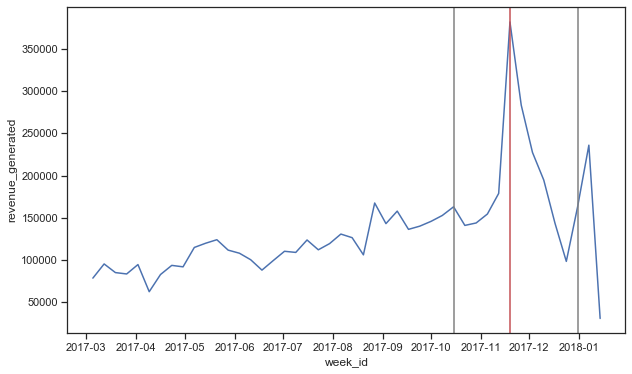

In [58]:
# 3.1
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=weekly_revenue,
             x=weekly_revenue.index,
             y="revenue_generated",
             ax=ax);

ax.axvline("2017-11-19", color="r");
ax.axvline("2017-10-15", color="grey");
ax.axvline("2017-12-31", color="grey");

In [59]:
import statsmodels.api as sm

In [67]:
# 3.2 create a time variable
rev_trend = weekly_revenue.copy()
rev_trend = rev_trend.sort_index().assign(t=range(1,len(weekly_revenue) + 1))

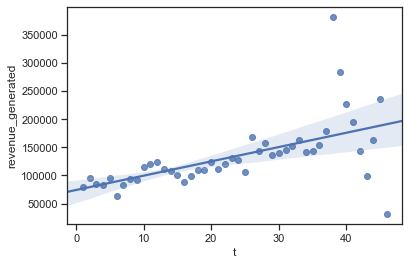

In [70]:
# 3.3 use seaborn built in regression to plot the trendline
sns.regplot(data=rev_trend,
            x="t",
            y="revenue_generated");

In [74]:
# 3.4 create column for estimation of the constant

# either manually
# rev_trend = rev_trend.assign(const=1)

# or using sm
rev_trend = sm.add_constant(rev_trend)

In [78]:
# 3.5 assume we only had data until "2017-10-15"
rev_trend_train = rev_trend.loc[:"2017-10-15"].copy()

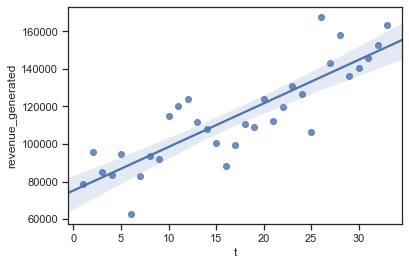

In [79]:
# 3.6 use seaborn built in regression to plot the trendline
sns.regplot(data=rev_trend_train,
            x="t",
            y="revenue_generated");

In [103]:
# 3.7 Fit line with statsmodels
y = rev_trend_train["revenue_generated"]
X = rev_trend_train[["const", "t"]]
lin_reg = sm.OLS(y, X)
result = lin_reg.fit()

In [102]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      revenue_generated   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     85.87
Date:                Mon, 11 Nov 2019   Prob (F-statistic):           1.91e-10
Time:                        15:06:52   Log-Likelihood:                -360.08
No. Observations:                  33   AIC:                             724.2
Df Residuals:                      31   BIC:                             727.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.522e+04   4873.597     15.435      0.000    6.53e+04    8.52e+04
t           2317.8239    250.120      9.267      0.000    1807.701    2827.947
==============================================================================
Omnibus:                        0.360   Durbin-Watson:                   1.594
Prob(Omnibus):                  0.835   Jarque-Bera (JB):                0.032
Skew:                           0.072   Prob(JB):                        0.984
Kurtosis:                       3.053   Cond. No.                         40.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$$revenue_i = const + t_i * trend$$
$$revenue_i = 75220 + t_i * 2317.82$$

From the regression output, I can plug in the coefficients into my model and appoly that to the dataframe

In [104]:
# 3.8 Plugging in the observations into our model
# First observation
75220 + 1*2317.82

77537.82

In [105]:
# second observation
75220 + 2*2317.82

79855.64

In [108]:
# 3.9 calculated predicted_revenue
rev_trend_train = rev_trend_train.assign(predicted_revenue=75220 + (rev_trend_train["t"] * 2317.82))

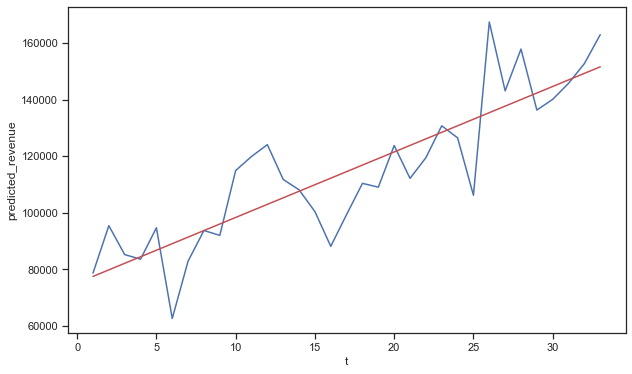

In [109]:
# 3.10 plot trendline
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=rev_trend_train,
             x="t",
             y="revenue_generated",
             ax=ax);

sns.lineplot(data=rev_trend_train,
             x="t",
             y="predicted_revenue",
             color="r",
             ax=ax);

In [115]:
# 3.11 Predicting forecasts for black friday period
rev_trend = rev_trend.assign(predicted_revenue=result.predict(rev_trend[["const", "t"]]))
rev_trend.tail()

,const,revenue_generated,t,predicted_revenue
week_id,,,,
2017-12-17,1.0,143431.610006,42,172571.979795
2017-12-24,1.0,98513.040154,43,174889.803680
2017-12-31,1.0,163005.200357,44,177207.627564
2018-01-07,1.0,236013.660486,45,179525.451449
2018-01-14,1.0,30962.530037,46,181843.275333


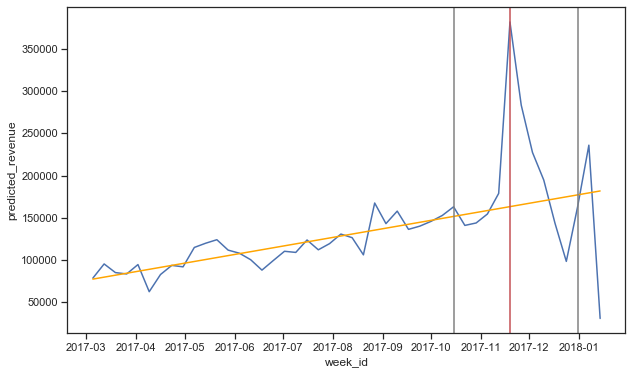

In [118]:
# 3.12 plot predictions
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=rev_trend,
             x=rev_trend.index,
             y="revenue_generated",
             ax=ax);

sns.lineplot(data=rev_trend,
             x=rev_trend.index,
             y="predicted_revenue",
             color="orange",
             ax=ax);

ax.axvline("2017-11-19", color="r");
ax.axvline("2017-10-15", color="grey");
ax.axvline("2017-12-31", color="grey");

In [122]:
# 3.13 calculate diff in observed and predicted revenue (errors)
black_friday_revenue = rev_trend["2017-10-15":"2017-12-31"]
black_friday_revenue = black_friday_revenue.assign(rev_diff=black_friday_revenue["revenue_generated"] - black_friday_revenue["predicted_revenue"])

In [123]:
black_friday_revenue.head()

,const,revenue_generated,t,predicted_revenue,rev_diff
week_id,,,,,
2017-10-15,1.0,163097.929827,33,151711.564836,11386.364991
2017-10-22,1.0,141077.580099,34,154029.388720,-12951.808621
2017-10-29,1.0,143962.440463,35,156347.212605,-12384.772141
2017-11-05,1.0,154567.200448,36,158665.036489,-4097.836041
2017-11-12,1.0,178951.390068,37,160982.860373,17968.529694


In [128]:
# 3.14 calculate sums
sums = black_friday_revenue[["revenue_generated", "predicted_revenue", "rev_diff"]].sum()

In [129]:
rel_diff_trend = (sums["revenue_generated"] / sums["predicted_revenue"]) - 1
abs_diff_trend = sums["rev_diff"]
print(f"""The revenue increased by {round(rel_diff_trend * 100)}% due to black friday compared to the our forecasts.
This represents an increase of revenue by {round(abs_diff_trend)} Reais.
""")

The revenue increased by 15.0% due to black friday compared to the our forecasts.
This represents an increase of revenue by 300467.0 Reais.



---

## Approach 4:
Fit a quadratic line!!!

In [130]:
# 4.1 create time variable
rev_quadr = weekly_revenue.copy()
rev_quadr = rev_quadr.sort_index().assign(t=range(1,len(rev_quadr) + 1))

In [134]:
# 4.2 create squared time variable to allow fitting a quadratic line
rev_quadr = rev_quadr.assign(t_sq=rev_quadr["t"] ** 2)

In [136]:
# 4.3 fit model with only observations prior to black friday period
rev_quadr = sm.add_constant(rev_quadr)
rev_quadr_train = rev_quadr.loc[:"2017-10-15"].copy()
y = rev_quadr_train["revenue_generated"]
X = rev_quadr_train[["const", "t", "t_sq"]]
lin_reg_quadr = sm.OLS(y, X)
result_quadr = lin_reg_quadr.fit()

/Users/at/miniconda3/envs/day1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [139]:
result_quadr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      revenue_generated   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     44.65
Date:                Mon, 11 Nov 2019   Prob (F-statistic):           1.02e-09
Time:                        15:44:28   Log-Likelihood:                -359.20
No. Observations:                  33   AIC:                             724.4
Df Residuals:                      30   BIC:                             728.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.263e+04   7522.907     10.984      0.000    6.73e+04     9.8e+04
t           1048.2097   1020.140      1.028      0.312   -1035.195    3131.614
t_sq          37.3416     29.107      1.283      0.209     -22.103      96.787
==============================================================================
Omnibus:                        1.407   Durbin-Watson:                   1.679
Prob(Omnibus):                  0.495   Jarque-Bera (JB):                0.549
Skew:                           0.253   Prob(JB):                        0.760
Kurtosis:                       3.379   Cond. No.                     1.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [143]:
# 4.4 predict black friday period
rev_quadr = rev_quadr.assign(predicted_revenue=result_quadr.predict(rev_quadr[["const", "t", "t_sq"]]))

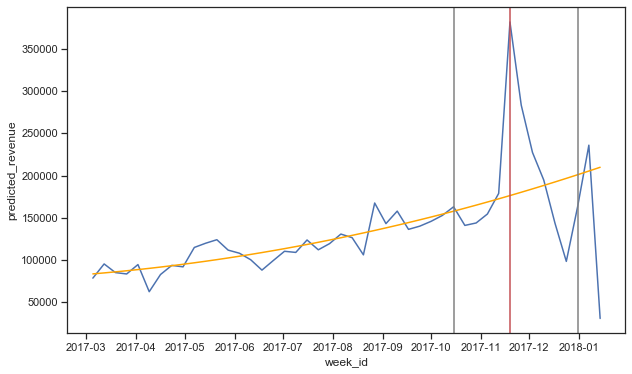

In [144]:
# 4.5 plot predictions
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=rev_quadr,
             x=rev_quadr.index,
             y="revenue_generated",
             ax=ax);

sns.lineplot(data=rev_quadr,
             x=rev_quadr.index,
             y="predicted_revenue",
             color="orange",
             ax=ax);

ax.axvline("2017-11-19", color="r");
ax.axvline("2017-10-15", color="grey");
ax.axvline("2017-12-31", color="grey");

In [147]:
black_friday_revenue_q = rev_quadr["2017-10-15":"2017-12-31"]
black_friday_revenue_q = black_friday_revenue_q.assign(rev_diff=black_friday_revenue_q["revenue_generated"] - black_friday_revenue_q["predicted_revenue"])
sums_quadr = black_friday_revenue_q[["revenue_generated", "predicted_revenue", "rev_diff"]].sum()

In [148]:
rel_diff_trend_q = (sums_quadr["revenue_generated"] / sums_quadr["predicted_revenue"]) - 1
abs_diff_trend_q = sums_quadr["rev_diff"]
print(f"""The revenue increased by {round(rel_diff_trend_q * 100)}% due to black friday compared to the our forecasts.
This represents an increase of revenue by {round(abs_diff_trend_q)} Reais.
""")

The revenue increased by 6.0% due to black friday compared to the our forecasts.
This represents an increase of revenue by 128621.0 Reais.

